In [1]:
import torch
import torch.nn as nn
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.05MB/s]


# Model: AutoEncoder (2-D bottleneck)
### What is an AutoEncoder (AE)?

An **AutoEncoder** learns to:
1) **Encode** an input \(x\) into a low-dimensional **latent vector** \(z\) (the **bottleneck**), and
2) **Decode** \(z\) back into a reconstruction \($\hat{x}\$) that resembles the original.

For MNIST (28×28 grayscale), we’ll use a **fully-connected (MLP: MultiLayer Perceptron) AE** with a **2-D bottleneck**:
- **Why 2-D?** So we can **visualize** the latent space later as a 2D scatter plot (each image → one point).
- **Encoder**: $(784 \rightarrow 300 \rightarrow 2)$
- **Decoder**: $(2 \rightarrow 300 \rightarrow 784)$

We keep it minimal:
- **Activations**: `LeakyReLU` after the hidden layers (helps gradients with small negative slope).
- **No output activation** on the decoder’s last layer because inputs are **standardized** (Mean=0.1307, Std=0.3081).  
  If you were using raw \([0,1]\) pixels, a `Sigmoid` could be sensible; with standardized inputs, an unrestricted linear output works well with L1/L2 losses.

---

### Shape flow

- Input batch \(x\): `[B, 1, 28, 28]`
- **Flatten** to `[B, 784]` before feeding the encoder.
- Encoder outputs \(z\): `[B, 2]`
- Decoder maps back to `[B, 784]`
- **Unflatten** to `[B, 1, 28, 28]` to compare against the original images.

This ensures the training loss can be computed as `loss(x, x_hat)` element-wise.

---

### Methods we implement

- `encode(x) → z`: only the encoder path (used later to visualize latents).
- `decode(z) → x_hat`: only the decoder path (used later to manipulate latents and decode).
- `forward(x) → x_hat`: full AE (encode then decode).

---

### Why `LeakyReLU`?

- Like ReLU but with a small slope on negatives (mitigates “dying ReLUs”).
- Often improves stability for simple MLP autoencoders.

---

### Sanity check idea (optional)

After defining the model, run a tiny batch through it and verify:
- `x.shape == recon.shape == [B, 1, 28, 28]`
- `features.shape == [B, 2]`

We’ll do that right after we instantiate the model.


### Why is it called a *bottleneck*?

In an autoencoder, the **bottleneck** is the **narrowest layer** in the middle — the smallest representation `z` through which all information about the input `x` must pass. By forcing data through this tight “neck,” the model must **compress** the input and keep only its most salient factors.

$$
\begin{array}{c}
x \in \mathbb{R}^{784} \xrightarrow{\text{Encoder}} z \in \mathbb{R}^{d} \xrightarrow{\text{Decoder}} \hat{x} \in \mathbb{R}^{784} \\
\text{(wide)} \quad \longrightarrow \quad \text{(narrow)} \quad \longrightarrow \quad \text{(wide)}
\end{array}
$$


---

### What the bottleneck does
- **Compression:** reduces dimensionality so the model captures key structure rather than copying pixels.  
- **Architectural regularization:** discourages the trivial identity mapping (especially when `d << D`).  
- **Generalization:** encourages discarding noise or redundancy and retaining meaningful features.

---

### Compression factor

Let `D` be the input dimensionality (e.g., `28 × 28 = 784` for MNIST) and `d` the bottleneck size.

$$
\text{compression factor} = \frac{D}{d}
$$

**Examples**
- `d = 2`  → \( \frac{784}{2} = 392\times \) compression (extreme; great for visualization).  
- `d = 64` → \( \frac{784}{64} \approx 12.25\times \) compression (typically better reconstructions).

---

### Choosing the bottleneck size `d` (trade-offs)
- **Too small `d`** → heavy compression → risk of **underfitting** (blurry or poor reconstructions).  
- **Too large `d`** → weak compression → risk of near **identity mapping** (little abstraction).  
- **Balanced `d`** → good reconstruction quality **and** compact, structured latents.

---

### Undercomplete vs. Overcomplete
- **Undercomplete** (`d < D`): a true *bottleneck*; capacity is limited by the latent dimensionality.  
- **Overcomplete** (`d ≥ D`): no geometric bottleneck; to avoid identity mapping you need extra regularization, e.g.:  
  - **Sparsity** penalties (e.g., L1 on activations),  
  - **Denoising** (corrupt input, reconstruct clean),  
  - **Contractive/variational** objectives (e.g., VAE).

---

### Why use a 2-D bottleneck in demos?
A 2-D latent `z` can be **plotted directly**: each image becomes a point in 2D, typically forming clusters by digit class. This makes the learned representation easy to interpret and debug.



In [2]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim: int = 2):
        super().__init__()
        # Flatten image to vector and back
        self.flatten   = nn.Flatten()                          # [B, 1, 28, 28] -> [B, 784]
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))  # [B, 784] -> [B, 1, 28, 28]

        # Encoder: 784 -> 300 -> bottleneck_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.LeakyReLU(),
            nn.Linear(300, bottleneck_dim)
        )

        # Decoder: bottleneck_dim -> 300 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 28*28)
            # No final activation since inputs are standardized; use L1/L2 loss.
            # If using raw [0,1] pixels, consider nn.Sigmoid() here.
        )

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)       # [B, 1, 28, 28] -> [B, 784]
        z = self.encoder(x)       # [B, 784] -> [B, bottleneck_dim]
        return z

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        x_hat = self.decoder(z)   # [B, bottleneck_dim] -> [B, 784]
        x_hat = self.unflatten(x_hat)  # [B, 784] -> [B, 1, 28, 28]
        return x_hat

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decode(self.encode(x))


# (Optional) quick shape sanity check
if __name__ == "__main__":
    model = AutoEncoder(bottleneck_dim=2)
    dummy = torch.randn(4, 1, 28, 28)     # batch of 4
    with torch.no_grad():
        z = model.encode(dummy)           # [4, 2]
        recon = model(dummy)              # [4, 1, 28, 28]
    print("z shape:", z.shape)
    print("recon shape:", recon.shape)


z shape: torch.Size([4, 2])
recon shape: torch.Size([4, 1, 28, 28])


### Why `Flatten` and `Unflatten` in an MLP AutoEncoder?

**Problem:** MNIST images arrive as 4D tensors `[B, C, H, W] = [B, 1, 28, 28]`, but `nn.Linear` layers expect 2D inputs `[B, F]`.

**Solution:**
- `nn.Flatten()` converts each image into a feature vector:
  $$
  [B, 1, 28, 28] \;\rightarrow\; [B, 28\cdot28] = [B, 784]
  $$
  so the encoder/decoder (which are MLPs) can operate on 2D tensors.

- `nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))` reshapes the decoder output 
  $$
  [B, 784] \;\rightarrow\; [B, 1, 28, 28]
  $$
  so the reconstruction $(\hat{x})$ has the **same shape** as the input \(x\).  
  This is required to compute pixel-wise losses (L1/MSE) and to **plot** the result as an image.

**When would you *not* need these?**
- In a **convolutional autoencoder** (Conv2d/ConvTranspose2d), you keep the data as `[B, C, H, W]` throughout, so no flatten/unflatten is needed.

**Why `dim=1` in `Unflatten`?**
- After `Flatten`, your tensor is `[B, 784]`:  
  - `dim=0` is the **batch**.  
  - `dim=1` is the **feature** dimension we want to reshape back into `(C, H, W)`.

**Alternatives**
- You could use `x = x.view(B, -1)` or `x = x.reshape(B, -1)` and the inverse reshape manually.  
  Using `nn.Flatten`/`nn.Unflatten` makes shapes explicit and shows up in `model` printouts for readability.

- `Flatten` lets MLPs consume images.  
- `Unflatten` restores image shape for loss/visualization.


### sanity-check snippet

In [3]:
B = 4
x = torch.randn(B, 1, 28, 28)

flat = torch.nn.Flatten()
unflat = torch.nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

x_vec = flat(x)                 # [B, 784]
# pretend the decoder produced a vector of the same size
x_hat_vec = x_vec.clone()       
x_hat = unflat(x_hat_vec)       # [B, 1, 28, 28]

print(x.shape, "->", x_vec.shape, "->", x_hat.shape)
# torch.Size([4, 1, 28, 28]) -> torch.Size([4, 784]) -> torch.Size([4, 1, 28, 28])


torch.Size([4, 1, 28, 28]) -> torch.Size([4, 784]) -> torch.Size([4, 1, 28, 28])


### Training an AutoEncoder

**Objective:** learn parameters so the decoder reconstructs the input from its latent \( z \).

We minimize a **reconstruction loss** between the input $( x )$ and output $( \hat{x} )$:
$$
\mathcal{L}(x, \hat{x}) =
\begin{cases}
\|x - \hat{x}\|_1 & \text{(L1 / MAE)} \\
\|x - \hat{x}\|_2^2 & \text{(MSE)}
\end{cases}
$$

**Choices (mirroring original notebook)**
- **Loss:** `nn.L1Loss()` (robust to outliers; often yields sharper reconstructions)
- **Optimizer:** `Adam(lr=1e-3)` (good default)
- **Epochs:** 3 (increase if underfitting)
- **Batch size:** 32
- **Device:** use GPU if available for speed

**Loop per batch**
1. `recon = model(x)` — forward pass (encode → decode)  
2. `loss = loss_fn(x, recon)` — compute reconstruction loss  
3. `optimizer.zero_grad()` — clear stale gradients  
4. `loss.backward()` — backpropagate  
5. `optimizer.step()` — update weights

**Training vs. Eval modes**
- `model.train()` enables training behavior (e.g., dropout/batchnorm updates).
- `model.eval()` disables those behaviors. We’ll use it later during inference/visualization.

**Sanity tips**
- Track and print the **mean epoch loss** to ensure it’s decreasing.
- If using GPU, remember: plotting/NumPy needs **CPU** tensors → call `.cpu()` before `.numpy()`.


**naming convention** for batches:
- `xb` = “**x batch**” (a tensor of many images)
- `yb` = “**y batch**” (a tensor of many labels)


### In an AutoEncoder
An AE learns to reconstruct its input, so the **target is the input**.
That’s why you often see the label **ignored** with `_`:

```python
for xb, _ in dl:           # labels unused in AE training
    recon = model(xb)
    loss = loss_fn(xb, recon) # target == input
```

In [4]:
from tqdm import tqdm
import torch

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Model + optimizer + loss
model = AutoEncoder(bottleneck_dim=2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()

# DataLoader
dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)

# Train
EPOCHS = 3
model.train()
for epoch in range(1, EPOCHS + 1):
    running_loss = 0.0
    total = 0

    pbar = tqdm(dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for xb, _ in pbar:
        xb = xb.to(DEVICE)                 # [B, 1, 28, 28]
        recon = model(xb)                  # [B, 1, 28, 28]
        loss = loss_fn(xb, recon)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        total += xb.size(0)
        pbar.set_postfix(loss=loss.item())

    mean_loss = running_loss / total
    print(f"Epoch {epoch}: mean L1 loss = {mean_loss:.6f}")


Device: cpu


Epoch 1: mean L1 loss = 0.342957


Epoch 2: mean L1 loss = 0.314709


Epoch 3: mean L1 loss = 0.305704


## Single-sample encode/decode + latent manipulation
### Goal
Understand what the 2-D latent space represents by:
1) **Encoding** one test image $(x)$ into its latent $(z)$,
2) **Decoding** to reconstruct $(\hat{x})$,
3) **Manipulating** $(z)$ (e.g., set \(z=[1,1]\)) and decoding again to see how the output changes.

### Key details
- **Batch dim:** The model expects batches. A single image `[1, 28, 28]` must become `[1, 1, 28, 28]`. We use `unsqueeze(0)` to add the batch dimension.
- **Eval mode:** `model.eval()` disables training-only behavior (good hygiene even if we don’t use dropout/batchnorm).
- **No gradients:** `with torch.no_grad():` avoids tracking gradients during inference.
- **Device:** Move tensors to the same device as the model; bring back to CPU for plotting (`.cpu()`).
- **Unnormalize for display:** We normalized inputs during loading (mean=0.1307, std=0.3081). To view images as typical grayscale, invert the transform:
  $$
  x_{\text{vis}} = \mathrm{clamp}(x \cdot 0.3081 + 0.1307,\, 0,\, 1)
  $$

### What to look for
- The **reconstruction** $(\hat{x})$ should look like the original digit (not perfect — this is a tiny AE).
- The **manipulated latent** often changes style/shape; with a 2-D $(z)$, moving along each axis tends to adjust some interpretable quality (e.g., stroke thickness, slant).


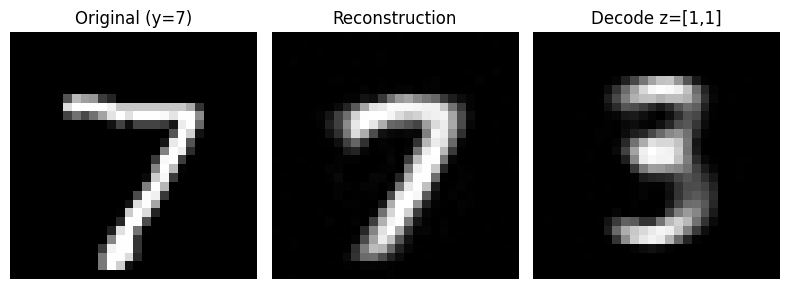

Original z: [[-0.7060627 -1.2232374]]
Edited   z: [[1. 1.]]


In [5]:
import torch
import matplotlib.pyplot as plt

# Helper to unnormalize a batch [B, 1, 28, 28] for display
def unnormalize(img_batch: torch.Tensor, mean=0.1307, std=0.3081):
    x = img_batch * std + mean
    return x.clamp(0, 1)

# Pick one test sample
x, y = test_mnist[0]          # x: [1, 28, 28], y: scalar label
x = x.unsqueeze(0)            # [1, 1, 28, 28] add batch dimension

model.eval()
with torch.no_grad():
    # Move to device
    x_device = x.to(DEVICE)

    # Encode -> z in R^2
    z = model.encode(x_device)            # [1, 2]

    # Reconstruct original
    x_recon = model.decode(z)             # [1, 1, 28, 28]

    # Manipulate latent (example: set z = [1, 1])
    z_edit = z.clone()
    z_edit[:, 0] = 1.0
    z_edit[:, 1] = 1.0

    x_recon_edit = model.decode(z_edit)   # [1, 1, 28, 28]

# Bring to CPU for plotting and unnormalize for nicer display
x_vis         = unnormalize(x.cpu())
x_recon_vis   = unnormalize(x_recon.cpu())
x_edit_vis    = unnormalize(x_recon_edit.cpu())

# Plot original, reconstruction, and edited-latent reconstruction
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].imshow(x_vis[0, 0].numpy(), cmap="gray")
axs[0].set_title(f"Original (y={y})")
axs[0].axis("off")

axs[1].imshow(x_recon_vis[0, 0].numpy(), cmap="gray")
axs[1].set_title("Reconstruction")
axs[1].axis("off")

axs[2].imshow(x_edit_vis[0, 0].numpy(), cmap="gray")
axs[2].set_title("Decode z=[1,1]")
axs[2].axis("off")

plt.tight_layout()
plt.show()

print("Original z:", z.cpu().numpy())
print("Edited   z:", z_edit.cpu().numpy())


## Encode the whole test set (collect latents + labels
### Goal
Compute the **2-D latent features** $(z \in \mathbb{R}^2)$ for **every** test image so we can visualize the learned space.

### Key details
- **Eval mode + no_grad:** we’re **not training**, so use `model.eval()` and `torch.no_grad()` to disable gradient tracking.
- **Batching:** use a `DataLoader` for the test set to process images efficiently.
- **Detach / CPU:** move outputs off the graph (`.detach()`), and to CPU (`.cpu()`) before converting to Python lists/NumPy for plotting.
- **Storage:** we’ll append per-batch results into Python lists, then stack/convert once at the end.


In [6]:
import torch

# DataLoader over the test set
test_dl = torch.utils.data.DataLoader(test_mnist, batch_size=32, shuffle=False)

model.eval()
allfeatures = []
allclasses = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)                      # [B, 1, 28, 28]
        z  = model.encode(xb)                   # [B, 2]
        allfeatures.extend(z.detach().cpu().tolist())
        allclasses.extend(yb.cpu().tolist())

# Convert to tensors for convenience (optional)
allfeatures = torch.tensor(allfeatures)         # [N, 2]
allclasses  = torch.tensor(allclasses)          # [N]
print("Latents shape:", allfeatures.shape, "Labels shape:", allclasses.shape)


Latents shape: torch.Size([10000, 2]) Labels shape: torch.Size([10000])


## Scatter plot of the 2-D latent space
### Goal
Visualize the **latent space** learned by the autoencoder: each test image becomes a **point** in 2D, colored by its digit label.

### What to look for
- **Clusters by class:** points with the same digit often cluster together if the latent captures class-related structure.
- **Overlap:** some digits may overlap (e.g., 4 vs 9) depending on model capacity/training.

### Plotting notes
- We pass the **labels** as the color vector `c=...`.  
- A small marker size (`s=1`) reduces overplotting on dense clouds.  
- A **qualitative colormap** like `'tab10'` maps labels 0–9 to distinct colors.  
- Add a colorbar with ticks 0–9 for readability.

> If your tensors were still on GPU, `.cpu()` is required before `.numpy()`; we already handled that during collection.


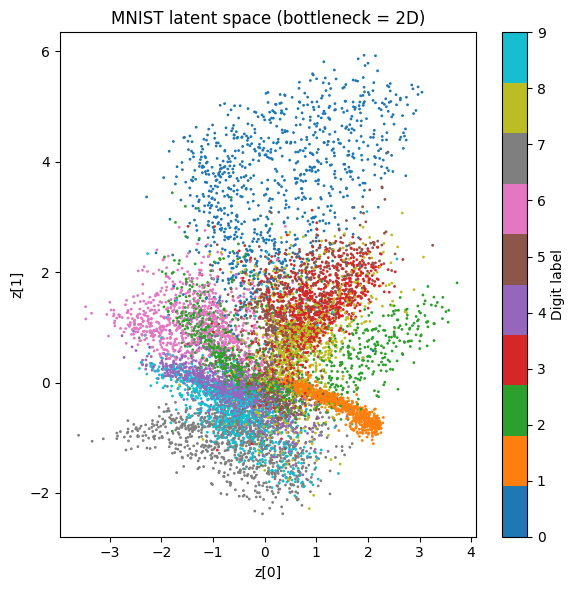

In [7]:
import matplotlib.pyplot as plt

# If you kept them as tensors, you can also convert to numpy:
xv = allfeatures[:, 0].numpy()
yv = allfeatures[:, 1].numpy()
cv = allclasses.numpy()

plt.figure(figsize=(6, 6))
sc = plt.scatter(xv, yv, c=cv, s=1, cmap="tab10")
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label("Digit label")
plt.title("MNIST latent space (bottleneck = 2D)")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.tight_layout()
plt.show()
